In [ ]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [ ]:
#make toy dataset
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples, noise= 0.03, random_state= 42)

In [ ]:
#make dataframe

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "Label": y})

circles.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


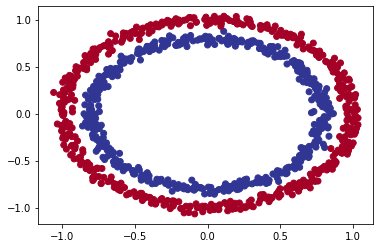

In [ ]:
#visualize

plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)

In [ ]:
#convert to tensor

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
#Split the data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    random_state= 42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cpu'

In [ ]:
#Building a model

from sklearn import datasets

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features= 2, out_features= 5)
    self.layer_2 = nn.Linear(in_features=5, out_features= 1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x))

#institate the instance of model

model0 = CircleModelV0().to(device)
model0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
#Replicate the above model using nn.Sequential()

model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features= 5),
    nn.Linear(in_features=5, out_features= 1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
type(X_test)

torch.Tensor

In [ ]:
#make preictions

with torch.inference_mode():
  untrained_preds = model0(X_test.to(device))

print(f"Length of Predicitons : {len(untrained_preds)}, Shape : {untrained_preds.shape}")
print(f"Length of test samples :{len(X_test)}, Shape : {X_test.shape}")

Length of Predicitons : 200, Shape : torch.Size([200, 1])
Length of test samples :200, Shape : torch.Size([200, 2])


In [ ]:
#Set loss fn
loss_fn = nn.BCEWithLogitsLoss()

#set optimizer
optimizer = torch.optim.SGD(params = model0.parameters(), lr = 0.1)

In [ ]:
#Calclate accuracy

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100

  return acc

In [ ]:
model0.eval()
with torch.inference_mode():
  y_logits = model0(X_test.to(device))[:5]
y_logits

tensor([[-0.4605],
        [-0.5110],
        [-0.2058],
        [-0.5332],
        [-0.0117]])

In [ ]:
#Use sigmoid fn
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.3869],
        [0.3750],
        [0.4487],
        [0.3698],
        [0.4971]])

In [ ]:
y_preds = torch.round(y_pred_prob)

y_pred_labels = torch.round(torch.sigmoid(model0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

In [ ]:
#Building a training and testing loop

torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model0.train()

  #forward pass
  y_logits = model0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true= y_train, y_pred=y_pred)

  #optimizer
  optimizer.zero_grad()

  #loss backwards
  loss.backward()

  #optimizer step
  optimizer.step()

  model0.eval()
  with torch.inference_mode():
    #forward pass
    test_logits = model0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)
    
    if epoch%10 == 0:
      print(f"Epoch:{epoch}, Loss :{loss:.5f}, Acc :{acc:.2f}%, Test loss:{test_loss:.5f}, Test acc : {test_acc:.2f}%")

Epoch:0, Loss :0.70586, Acc :40.88%, Test loss:0.69949, Test acc : 42.00%
Epoch:10, Loss :0.69903, Acc :46.50%, Test loss:0.69357, Test acc : 50.00%
Epoch:20, Loss :0.69662, Acc :47.75%, Test loss:0.69183, Test acc : 51.00%
Epoch:30, Loss :0.69556, Acc :48.88%, Test loss:0.69137, Test acc : 51.00%
Epoch:40, Loss :0.69496, Acc :49.12%, Test loss:0.69133, Test acc : 52.00%
Epoch:50, Loss :0.69454, Acc :48.75%, Test loss:0.69142, Test acc : 53.00%
Epoch:60, Loss :0.69423, Acc :49.00%, Test loss:0.69158, Test acc : 53.00%
Epoch:70, Loss :0.69399, Acc :49.12%, Test loss:0.69175, Test acc : 54.50%
Epoch:80, Loss :0.69379, Acc :49.25%, Test loss:0.69194, Test acc : 55.00%
Epoch:90, Loss :0.69364, Acc :49.25%, Test loss:0.69212, Test acc : 54.50%


In [ ]:
#download helper functions from another repo
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("File already exists")
else:
  print("File downloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

File already exists


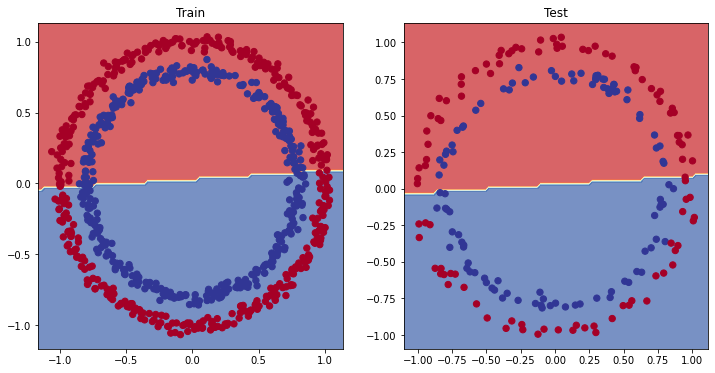

In [ ]:
#visualize decision boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

In [ ]:
#Imporving the model

class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features = 2, out_features= 10)
    self.layer2 = nn.Linear(in_features = 10, out_features= 10)
    self.layer3 = nn.Linear(in_features = 10, out_features= 1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

model1 = CircleModelV1().to(device)
model1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#create a loss fn
loss_fn = nn.BCEWithLogitsLoss()

#create an optimizer
optimizer = torch.optim.SGD(params = model1.parameters(), lr = 0.1)

In [ ]:
# Training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
#print(X_train.shape)

for epoch in range(epochs):
  #training
  model1.train()

  #forward pass
  y_logits = model1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #print(y_logits.shape, y_train.shape)
  #calculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
  
  optimizer.zero_grad()

  #loss backward
  loss.backward()

  #optimizer
  optimizer.step()

  #Testing
  model1.eval()
  with torch.inference_mode():
    #forward pass
    test_logits = model1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred = test_pred)

    if epoch %100 == 0:
      print(f"Epoch:{epoch}, Loss :{loss:.5f}, Acc :{acc:.2f}%, Test loss:{test_loss:.5f}, Test acc : {test_acc:.2f}%")

Epoch:0, Loss :0.69517, Acc :52.50%, Test loss:0.70113, Test acc : 47.50%
Epoch:100, Loss :0.69303, Acc :50.88%, Test loss:0.69547, Test acc : 47.00%
Epoch:200, Loss :0.69298, Acc :51.50%, Test loss:0.69487, Test acc : 46.00%
Epoch:300, Loss :0.69298, Acc :51.50%, Test loss:0.69473, Test acc : 44.50%
Epoch:400, Loss :0.69298, Acc :51.12%, Test loss:0.69469, Test acc : 45.50%
Epoch:500, Loss :0.69298, Acc :51.00%, Test loss:0.69468, Test acc : 46.00%
Epoch:600, Loss :0.69298, Acc :51.00%, Test loss:0.69468, Test acc : 46.00%
Epoch:700, Loss :0.69298, Acc :51.00%, Test loss:0.69468, Test acc : 46.00%
Epoch:800, Loss :0.69298, Acc :51.00%, Test loss:0.69468, Test acc : 46.00%
Epoch:900, Loss :0.69298, Acc :51.00%, Test loss:0.69468, Test acc : 46.00%


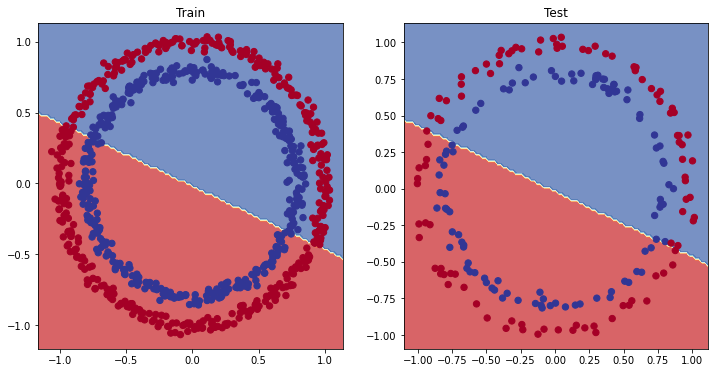

In [ ]:
#visualize decision boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

In [ ]:
#Model with non linear activation function

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model3 = CircleModelV2().to(device)
model3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
#loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr = 0.1)

In [ ]:
#Training
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
#print(X_train.shape)



for epoch in range(epochs):
  model3.train()

  #forward pass
  # y_logits = model3(X_train).squeeze()
  # y_pred = torch.round(torch.sigmoid(y_logits))
  # 
  y_logits = model3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  #print(y_logits.shape, y_train.shape)
  #calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

  #optimizer zero grad
  optimizer.zero_grad()

  #loss backward
  loss.backward()

  #step the optimizer
  optimizer.step()

  #Testing
  model3.eval()
  with torch.inference_mode():
    test_logits = model3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

    if epoch %100 == 0:
      print(f"Epoch:{epoch}, Loss :{loss:.5f}, Acc :{acc:.2f}%, Test loss:{test_loss:.5f}, Test acc : {test_acc:.2f}%")

Epoch:0, Loss :0.69295, Acc :50.00%, Test loss:0.69319, Test acc : 50.00%
Epoch:100, Loss :0.69115, Acc :52.88%, Test loss:0.69102, Test acc : 52.50%
Epoch:200, Loss :0.68977, Acc :53.37%, Test loss:0.68940, Test acc : 55.00%
Epoch:300, Loss :0.68795, Acc :53.00%, Test loss:0.68723, Test acc : 56.00%
Epoch:400, Loss :0.68517, Acc :52.75%, Test loss:0.68411, Test acc : 56.50%
Epoch:500, Loss :0.68102, Acc :52.75%, Test loss:0.67941, Test acc : 56.50%
Epoch:600, Loss :0.67515, Acc :54.50%, Test loss:0.67285, Test acc : 56.00%
Epoch:700, Loss :0.66659, Acc :58.38%, Test loss:0.66322, Test acc : 59.00%
Epoch:800, Loss :0.65160, Acc :64.00%, Test loss:0.64757, Test acc : 67.50%
Epoch:900, Loss :0.62362, Acc :74.00%, Test loss:0.62145, Test acc : 79.00%
Epoch:1000, Loss :0.56818, Acc :87.75%, Test loss:0.57378, Test acc : 86.50%
Epoch:1100, Loss :0.48153, Acc :93.50%, Test loss:0.49935, Test acc : 90.50%
Epoch:1200, Loss :0.37056, Acc :97.75%, Test loss:0.40595, Test acc : 92.00%
Epoch:1300,

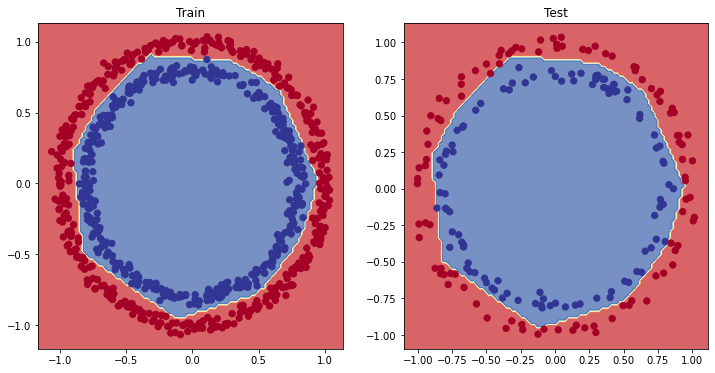

In [ ]:
#visualize decision boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test)

In [ ]:
#Multi class classification

In [ ]:
# #create toy data set

# from sklearn.datasets import make_blobs

# NUM_CLASSES = 4
# NUM_FEATURES = 2
# RANDOM_SEED = 42

# #create multi class data

# X_blob, y_blob = make_blobs(n_samples = 1000, n_features = NUM_FEATURES,
#                             centers = NUM_CLASSES, cluster_std= 1.5, random_state = RANDOM_SEED)

# #turn data into tensor

# X_blob = torch.from_numpy(X_blob).type(torch.float)
# y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
# print(X_blob[:5], y_blob[:5])
# #split into train and split

# X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size = 0.2,
#                                                                         random_state = RANDOM_SEED)

# #visualize
# plt.figure(figsize = (10,7))
# plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu)

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


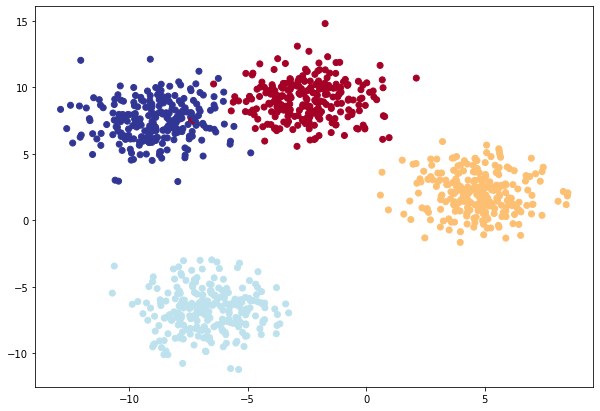

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [ ]:
# #Build a multi class model

# class BlobModel(nn.Module):
#   def __init__(self, input_features, output_features, hidden_units = 8):
#     super().__init__()
#     self.linear_layer_stack = nn.Sequential(
#         nn.Linear(in_features = input_features, out_features = hidden_units),
#         nn.Linear(in_features = hidden_units, out_features = hidden_units),
#         nn.Linear(in_features = hidden_units, out_features = output_features)
#     )
  
#   def forward(self, x):
#         return self.linear_layer_stack(x)

# model4 = BlobModel(input_features = 2, output_features = 4,
#                    hidden_units = 8).to(device)
# model4

In [ ]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
# #loss and optimizier

# loss_fn = nn.CrossEntropyLoss()
# # optimizer = torch.optim.SGD(params = model4.parameters(), lr = 0.1)
# optimizer = torch.optim.SGD(model4.parameters(), lr = 0.1)

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1)

In [ ]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [ ]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [ ]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


In [ ]:
torch.sum(y_pred_probs[0])


tensor(1., grad_fn=<SumBackward0>)

In [ ]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


In [ ]:
# #creating testing and training loop

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# epochs = 100

# X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
# X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# for epoch in range(epochs):
#   model_4.train()

#   y_logits = model_4(X_blob_train)
#   y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

#   loss = loss_fn(y_logits, y_blob_train)
#   acc = accuracy_fn(y_true = y_blob_train, y_pred = y_pred)

#   optimizer.zero_grad
#   loss.backward()
#   optimizer.step()

#   model_4.eval()
#   with torch.inference_mode():
#     test_logits = model_4(X_blob_test)
#     test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)
#     test_loss = loss_fn(test_logits, y_blob_test)
#     test_acc = accuracy_fn(y_true = y_blob_test, y_pred = test_preds)

#     if epoch % 10 == 0:
#       print(f"Epoch:{epoch}, Loss :{loss:.5f}, Acc :{acc:.2f}%, Test loss:{test_loss:.5f}, Test acc : {test_acc:.2f}%")

In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


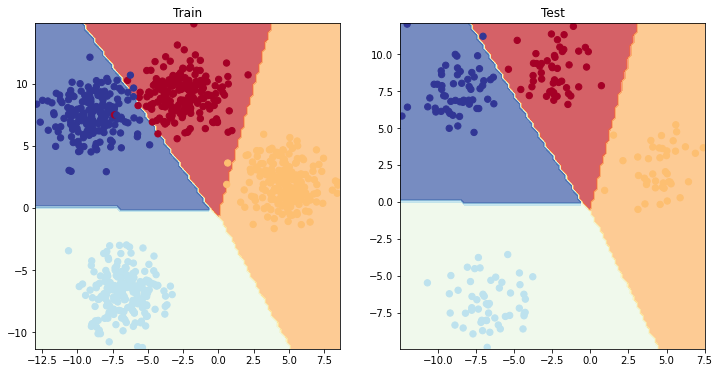

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

from torchmetrics import Accuracy
# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy.to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

AttributeError: ignored